# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---
- José Miguel Chacón
- Víctor Gómez 
- Germán Portilla

Sistemas Cognitivos Artificiales, 30 de Mayo de 2022

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10674176/10658925 [==============================] - 0s 0us/step


In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

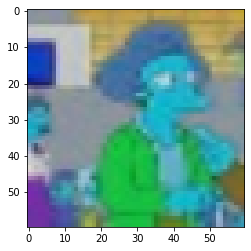

In [ ]:
plt.imshow(X_t[2]) # recordad que siempre es preferible trabajar en blanco y negro

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

### Transformación de los datos

In [ ]:
# Imprimimos el shape de los datos de entrenamiento y test
# En este apartado se analiza el comportamiento de los datos para entrenamiento y testeo, dando como resultado que se tienen al menos 18 mil imagenes con un tamaño de 60X60 
# y definidas en tres canales RGB
print(X.shape, X_t.shape)
print(y.shape, y_t.shape)

(18992, 60, 60, 3) (890, 60, 60, 3)
(18992,) (890,)


In [ ]:
# Transformamos las variables a categoricas
# Se usa una tranformacion a las variables para su uso apartir de la funcionalidad de el paquete Keras, al no ejecutar el cambio a categorical se genera un error de manejo
# cabe aclarar que los datos son de estructura un signed entero de 8 bits.

train_labels = keras.utils.to_categorical(y, dtype ="uint8")
test_labels = keras.utils.to_categorical(y_t, dtype ="uint8")

In [ ]:
# Normalizamos
# Debido a que los datos tienen valores por encima de 255 en algunos segmentos, se genera un proceso de normalizado que garantiza un comportamiento idoneo de las datas, puesto que seran interprestadas de manera correcta por el clasificador y optimizador.
# Este paso es relevante en la mayoria de ejercicios para mejorar el accuracy arrojado.

X, X_t = X/255, X_t/255

### Métodos útiles

In [ ]:
# Callback para finalizar el entrenamiento al llegar al 95% de accuracy
''' Mediante este bloque se busca reducir el conjunto de epochs generados en el apartado de entrenamiento evitanto el overfitting en los resultados, 
se precisa que esta estructura de callback es tomado del ejercicio anterior donde se buscaba que el sistema se detuviera al generar un modelo optimo del proceso de separacion y
clasificacion de la CNN evitando que multiples epochs se reproduzcan y se genere gasto computacvional elevado al encontrar una solucion adecuada al problema.
'''

class customCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95):
              print("\nAlcanzado el 95% de accuracy, ¡Se finaliza el entrenamiento!")
              self.model.stop_training = True
              
# Esta función permite imprimir las matrices de confusión utilizando seaborn
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

### Definición de los modelos

In [ ]:
# Lista para guardar los modelos que se diseñarán a continuación
# Es necesario para almacenar los datos, que se suministran en el entrenamiento de la CNN.
models = []

#### Definición del modelo 1
- Antes de continuar, cada modelo diseñado se guardará en la lista *models*.

En este apartado se presenta la generacion del primer modelo, mediante una secuencia de pasos dadas por la CNN. Podemos ver que no es necesario el uso de una capa Flatten al comienzo, dado que estas redes trabajan con datos espaciales. Para este caso se presenta redundancia en las sentencias para declarar las convoluciones, cada una de estas se replica dos veces, generando mayor cantidad de convoluciones que darán resultados en un proceso de comparacion y que indican si es práctico redundar en las capas usadas, los parámetros del kernel de inicializacion es *he_uniform*, basado en una distribucion uniforme comprendida en un intervalo cerrado de a y b, este tipo de inicializador tiene una media de 1/2 lo que indica que la separacion del comportamiento se mantiene y su varianza aproximadamente 1/12, son características desde el punto de vista de distribucion de probabilidad que otorgan resultados que se veran mas adelante.

Se generan 2 convoluciones más una capa maxpooling, 3 veces con el mismo patrón, luego para este modelo se usa una capa Flatten para aplanar los datos y finalmente una capa Softmax para realizar la clasificación con 18 neuronas, como se puede apreciar en la siguiente ilutración.


In [ ]:
models.append(tf.keras.Sequential([
  keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform',
                      padding = 'same', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
  keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform',
                      padding= 'same', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
  keras.layers.MaxPooling2D((2,2)),
  keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding = 'same'),
  keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding = 'same'),
  keras.layers.MaxPooling2D((3, 3)),
  keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding = 'same'),
  keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding = 'same'),
  keras.layers.MaxPooling2D((3, 3)),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation = 'relu', kernel_initializer='he_uniform'),
  keras.layers.Dense(18, activation = 'softmax')
]))

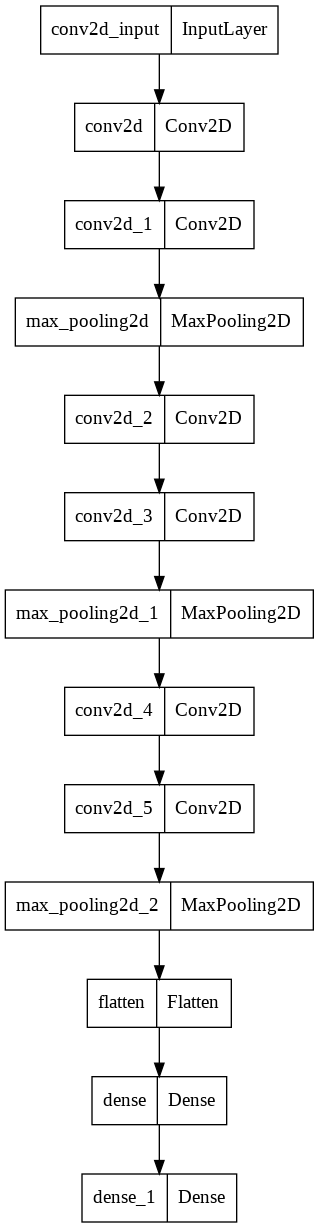

In [ ]:
plot_model(models[len(models)-1])

#### Definición del modelo 2
Este modelo presenta el mismo inicializador de kernel pero presenta una modificacion en la estrucutura redundante dell modelo 1, para este caso se eleiminan las sentencias adicionales para cada salto, se puede decir que es una version simplificada de la anterior pero con resultados similares, lo que puede indicar que la clasificacion no depende de las sentencias adicionales si no del comportamiento de las inicializaciones y steps sobre los datos, puesto que para este caso se eliminan y los resultados son similares en alto grado,  la estrucutra de capas se puede apreciar en la siguiente imagen. 

In [ ]:
models.append(tf.keras.Sequential([
  keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                      padding = 'same', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
  keras.layers.MaxPooling2D((2,2)),
  keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding = 'same'),
  keras.layers.MaxPooling2D((3, 3)),
  keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer='he_uniform', padding = 'same'),
  keras.layers.MaxPooling2D((3, 3)),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation = 'relu', kernel_initializer='he_uniform'),
  keras.layers.Dense(18, activation = 'softmax')
]))

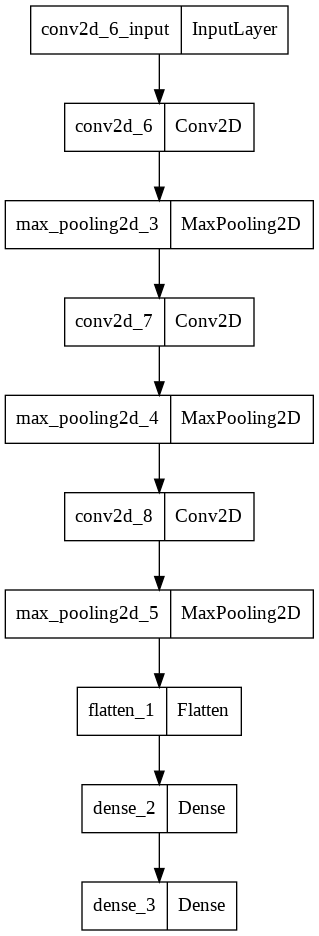

In [ ]:
plot_model(models[len(models)-1])

#### Definición del modelo 3
En este modelo se presentan modificaciones sobre el conjunto de convolución, la capa dense con aumentos significativos, en los modelos anteriores se presentaba almenos una capa Dense de 128 y en este caso 1024 lo que aporta un conjunto mayor de iteraciones y gasto computacional, pero  adicionalmente se añade una capa Dropout que es una regulacion con un factor de 0.5 esto hará que los datos tienen a una metrica mas uniforme, al final la capa del Softmax es igual puesto que las clases o  etiquetas no ha aumentado.
En la siguiente figura se puede apreciar la estrucutra de la CNN de modelo.

In [ ]:
models.append(tf.keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  keras.layers.MaxPooling2D(pool_size=(2,2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3),padding='same',activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2,2)),
  keras.layers.Conv2D(256, (3, 3),padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2,2)),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(18, activation='softmax')
]))

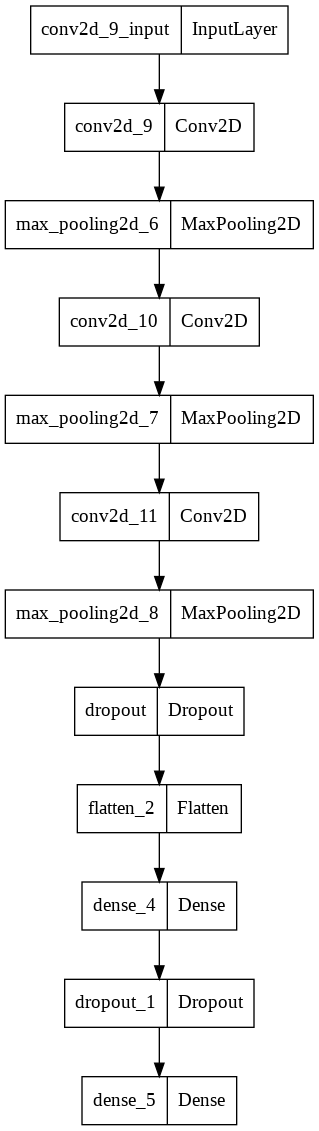

In [ ]:
plot_model(models[len(models)-1])

#### Definición del modelo 4
Este modelo 4 no es tan diferente del anterior, pero se debe presentar variaciones que permitan correlacionar y establecer la eficiencia entre los modelos generados.
Para este caso se tiene una estrcutura de sentencias de convolución, maxpooling almenos por 3 veces pero al llegar a la disminución dimensional de la capa flatten se opta por no colocar la sentencia Dense de 1024 como en el paso anterior sino que se pasa al proceso de Dropout con el mismo factor de 0.5 y una dense menos a 512 luego se finaliza con la dense a 18. Se puede apreciar la estrucutra en la imagenen siguiente.

In [ ]:
models.append(tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
]))

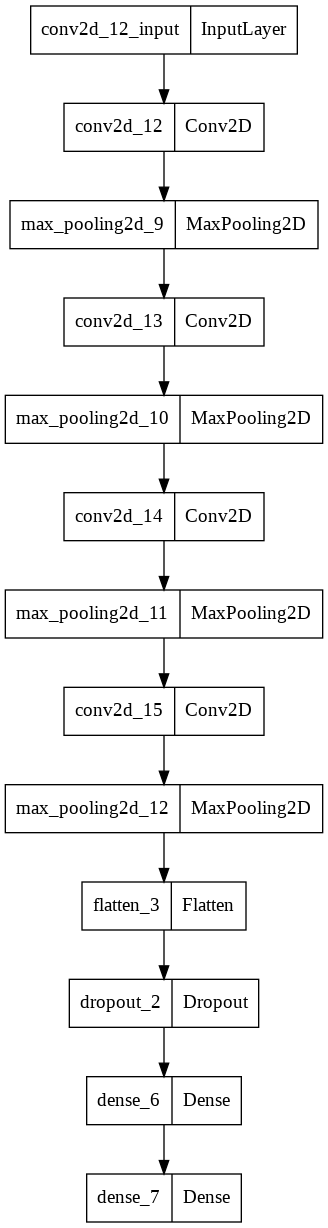

In [ ]:
plot_model(models[len(models)-1])

#### Definición del modelo 5
En este modelo se implementa una función callback cuándo se llega al 95% de accuracy.
Este modelo presenta algunos cambios significativos que van en pro de la mejora en la clasificacion pero creando alternativasd versionadas con cambio de parametros, se usan almenos 3 secuencias en Convolucion y maxpooling  junto a comportamiento de aumento 32, 64 y 256, se vuelve a incluir una capa Dense de 1024 pero esta vez para evitar
el suso continuo de epochs se hace el llamado al Callback de mayor accuracy por encima del 95%, 10 puntos porcentuales enciam de lo propuesto en la actividad. Se puede apreciar la estructura estimada, en el siguiente grafico. 


In [ ]:
models.append(tf.keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3),padding='same',activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(256, (3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(18, activation='softmax')
]))
# Asignacion del callback
callbackAccuracy = customCallback()

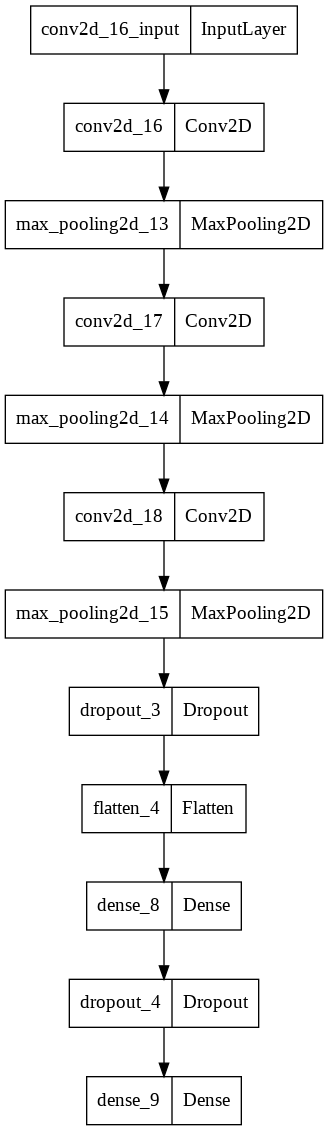

In [ ]:
plot_model(models[len(models)-1])

#### Definición del modelo 6
En este modelo se implementan tres capas BatchNormalization.
Para este modelo, los cambios se ejecutan sobre la misma estructura de los anteriores, pero se adiciona un Batchnormalization, que genera un ajuste al conjunto de catos en cada resultado previo, en este caso se hace llamado a la funcion que calcula una distancia entre los vectores y posteriormente normaliza, usa la desviacion estandar para afinar el resultado. Se presentan almenos 3 capas de este llamado a funcion, tambien se mantienen la capa dense en 1024 con un Dropout de factor 0.5. 


In [ ]:

models.append(tf.keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(3, 3),padding='same',activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(18, activation='softmax')
]))

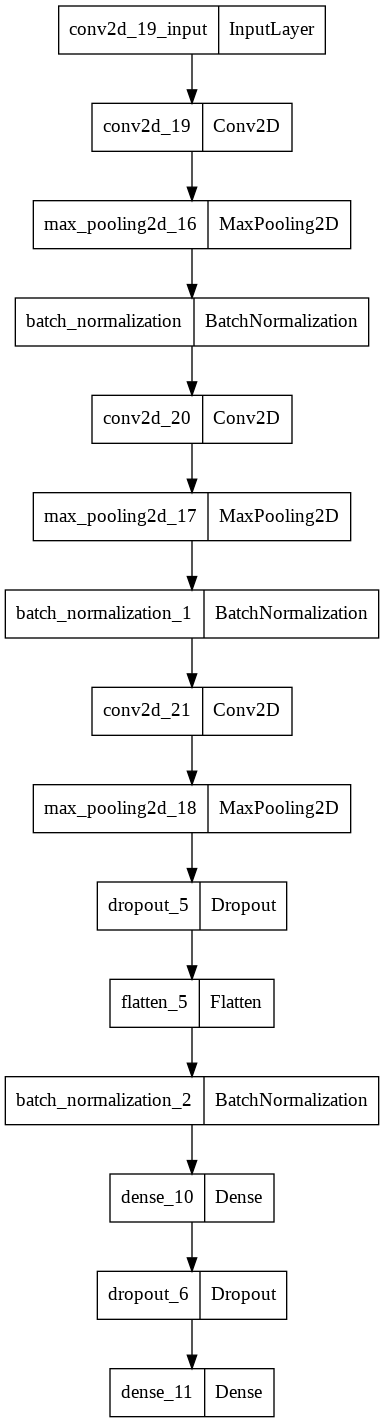

In [ ]:
plot_model(models[len(models)-1])

In [ ]:
# Optimizadores
# Se usa un optimizador general que presenta buenos resultados, SGD, con  los parametros indicados a continuacion. 

sgd = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)

### Entrenamiento

In [ ]:
# Lista para guardar la información del entrenamiento de cada modelo
histories = []

In [ ]:
# Entrenamiento de los modelos, el modelo 5 detiene  su entrenamiento al alcanzar el 95% de accuracy mientras que los demás, culminan segun el numero de epochs.

for key, model in enumerate(models):
  print("------ Entrenando el modelo " + str(key + 1) + "...")
  model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics=['accuracy'])
  if key == 4:
    histories.append(model.fit(X, train_labels, epochs = 15, batch_size=64, validation_data=(X_t, test_labels), callbacks=[callbackAccuracy], verbose= 1))
  else:
    histories.append(model.fit(X, train_labels, epochs = 15, batch_size=64, validation_data=(X_t, test_labels), verbose= 1))

------ Entrenando el modelo 1...
Epoch 1/15
297/297 [==============================] - 17s 21ms/step - loss: 2.1259 - accuracy: 0.3487 - val_loss: 1.4505 - val_accuracy: 0.5528
Epoch 2/15
297/297 [==============================] - 6s 19ms/step - loss: 1.1769 - accuracy: 0.6445 - val_loss: 0.9554 - val_accuracy: 0.7056
Epoch 3/15
297/297 [==============================] - 6s 19ms/step - loss: 0.7744 - accuracy: 0.7613 - val_loss: 0.7293 - val_accuracy: 0.7742
Epoch 4/15
297/297 [==============================] - 6s 19ms/step - loss: 0.5713 - accuracy: 0.8256 - val_loss: 0.5126 - val_accuracy: 0.8427
Epoch 5/15
297/297 [==============================] - 6s 19ms/step - loss: 0.4090 - accuracy: 0.8759 - val_loss: 0.2921 - val_accuracy: 0.9090
Epoch 6/15
297/297 [==============================] - 6s 19ms/step - loss: 0.2915 - accuracy: 0.9118 - val_loss: 0.2013 - val_accuracy: 0.9371
Epoch 7/15
297/297 [==============================] - 6s 19ms/step - loss: 0.2258 - accuracy: 0.9298 - val_l

### Métricas

Métricas para el modelo 1


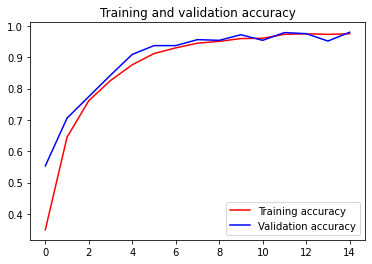

<Figure size 432x288 with 0 Axes>

Métricas para el modelo 2


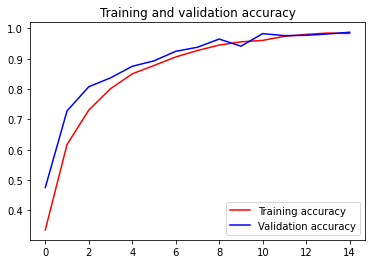

<Figure size 432x288 with 0 Axes>

Métricas para el modelo 3


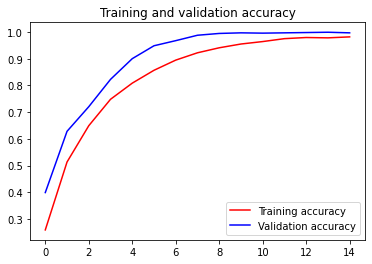

<Figure size 432x288 with 0 Axes>

Métricas para el modelo 4


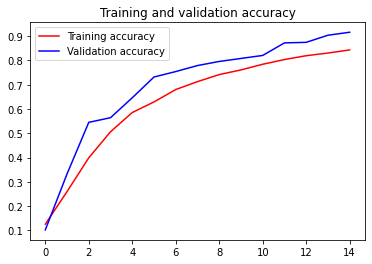

<Figure size 432x288 with 0 Axes>

Métricas para el modelo 5


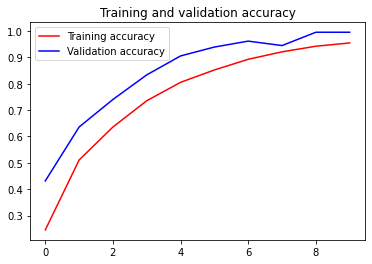

<Figure size 432x288 with 0 Axes>

Métricas para el modelo 6


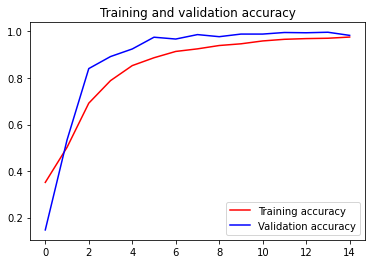

<Figure size 432x288 with 0 Axes>

In [ ]:
# Dentro del conjunto de metricas se presentan las graficas para cada uno de los modelos, segun lo que se puede apreciar todos trabajan de manera similar
# con porcentajes superiores al 87%, pero algunos presentan alteraciones en los resultados y fluctuacciones que pueden deberse al manejo de los paramatros en 
# cada generacion, se presentan en los graficos dos tendencias, una es el accuracy denentrenamiento y otro es el de la validacion, todos los resultados son relevantes
# y buenos, pero la tendencia grafica de comportamiento es mejor en el  modelo 3 obteniendo una curva de compoortamiento similar a la de los datos, con un accuracy superior al 99%.


import matplotlib.pyplot as plt

for key, history in enumerate(histories):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  print("Métricas para el modelo " + str(key + 1))
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

#### Score sobre los datos de test de cada modelo

Con la informacion de cada modelo se extraen parametros relevantes respecto al loss y accuracy, y se puede notar que el modelo 3 presenta la mejor separacion de cada una de las clases. y el modelo que menor accuracy arrojó de los 3 es el modelo 4, pero cercano al 90%, algo distante de los demas modelos, los cuales dieron resultados satisfactorios, para el caso del modelo 1 que presentaba redundancia de capas el resultado es del 96% mientras que el modelo 2 que es de estructura similar pero sin las capas adicionales entrega mejor accuracy, lo que indica que el aumentar las capas no siempre entrega buenos resultados, y que ademas puede generar aumento de gasto computacional, los demas modelos con las modificaciones adicionales de Batchnormalization no difieren de manera abrupta de los demas resultados y no lo tienen, ademas que el añadir la cpata Dropout puede mejorar pero depende de la situacion generada para cada modelo.


In [ ]:
for key, model in enumerate(models):
  print("Evaluación del modelo " + str(key + 1))
  score = model.evaluate(X_t, test_labels, verbose = 1)

Evaluación del modelo 1
28/28 [==============================] - 0s 9ms/step - loss: 0.0600 - accuracy: 0.9798
Evaluación del modelo 2
28/28 [==============================] - 0s 3ms/step - loss: 0.0410 - accuracy: 0.9876
Evaluación del modelo 3
28/28 [==============================] - 0s 5ms/step - loss: 0.0152 - accuracy: 0.9966
Evaluación del modelo 4
28/28 [==============================] - 0s 6ms/step - loss: 0.2883 - accuracy: 0.9157
Evaluación del modelo 5
28/28 [==============================] - 0s 4ms/step - loss: 0.0388 - accuracy: 0.9955
Evaluación del modelo 6
28/28 [==============================] - 0s 5ms/step - loss: 0.0516 - accuracy: 0.9831


#### Reporte de clasificación por cada clase

Para cada uno de los resultados de modelo, se puede estrablecer metricas con mayor cantidad de datos, para este caso se presenta la precision,  recall y el F1 Score estos datos se dan para cada uno de los modelos junto a matrices de correlacion para cada una de las clases, como los p orcentajes de accuracy varian en unos puntos porcentuales.
Los resultados presentados son similares pero eso se debe a la cercania en los resultados de cada modelo, la diferencia se dara en las matrices en un par de puntos, por encima o por debajo pero es comun cuando se solapan los accuracy y Loss en cada una de las madidas, para el caso del modelo 4 que difiere en almenos 10 puntos porcentuales el cambio es significativo y se puede apreciar que esos puntos alejan los resultados de los demas modelos.


Reporte por cada clase del modelo 1
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        48
           1       1.00      1.00      1.00        50
           2       0.92      0.98      0.95        50
           3       1.00      0.88      0.93        48
           4       0.94      1.00      0.97        50
           5       1.00      0.96      0.98        49
           6       1.00      0.98      0.99        50
           7       0.93      1.00      0.96        50
           8       0.98      1.00      0.99        50
           9       1.00      1.00      1.00        50
          10       1.00      0.90      0.95        50
          11       0.98      1.00      0.99        50
          12       0.98      1.00      0.99        49
          13       0.96      1.00      0.98        50
          14       1.00      1.00      1.00        49
          15       1.00      0.98      0.99        50
          16       1.00      0.98      0.99  

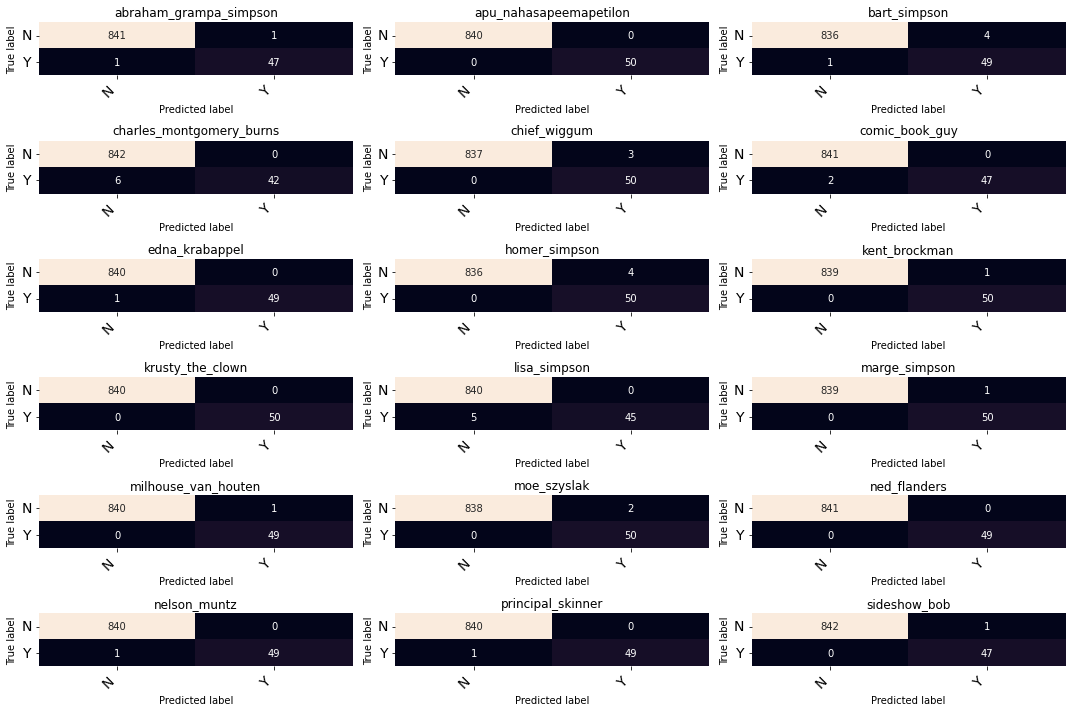

Reporte por cada clase del modelo 2
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      1.00      1.00        50
           2       0.98      0.98      0.98        50
           3       1.00      1.00      1.00        48
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        49
           6       0.98      0.98      0.98        50
           7       1.00      0.96      0.98        50
           8       1.00      1.00      1.00        50
           9       0.98      1.00      0.99        50
          10       1.00      0.94      0.97        50
          11       1.00      1.00      1.00        50
          12       0.98      1.00      0.99        49
          13       1.00      0.94      0.97        50
          14       1.00      0.98      0.99        49
          15       0.96      1.00      0.98        50
          16       0.94      1.00      0.97  

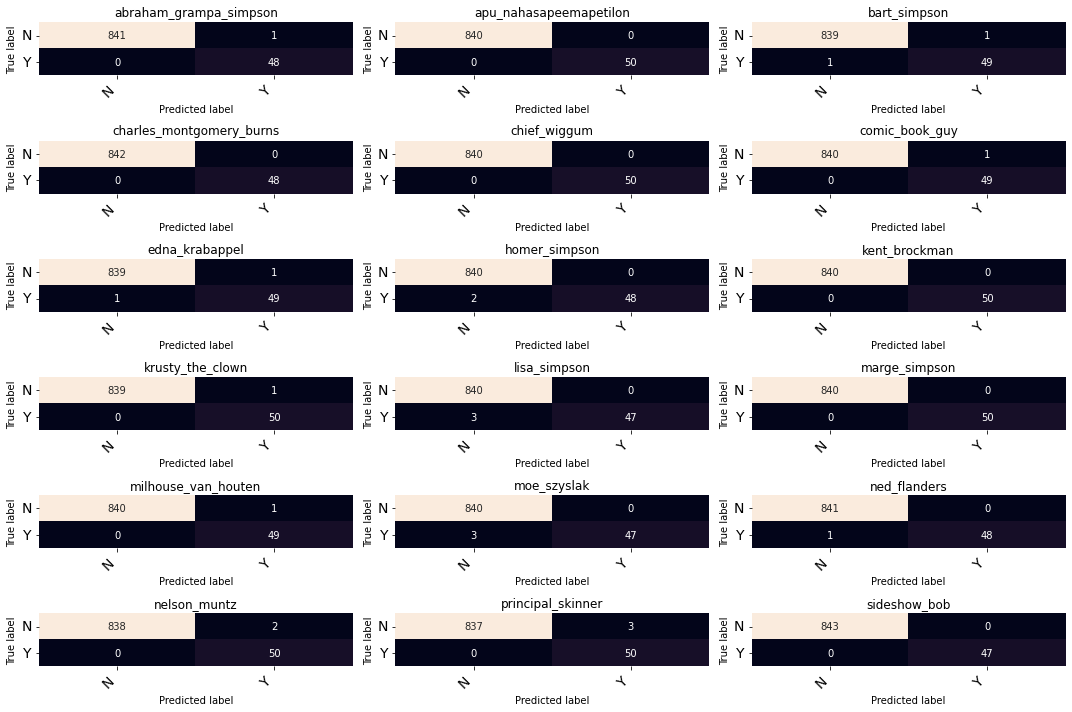

Reporte por cada clase del modelo 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        50
           2       0.98      1.00      0.99        50
           3       1.00      1.00      1.00        48
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        49
           6       1.00      0.98      0.99        50
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        50
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        49
          15       1.00      1.00      1.00        50
          16       0.98      1.00      0.99  

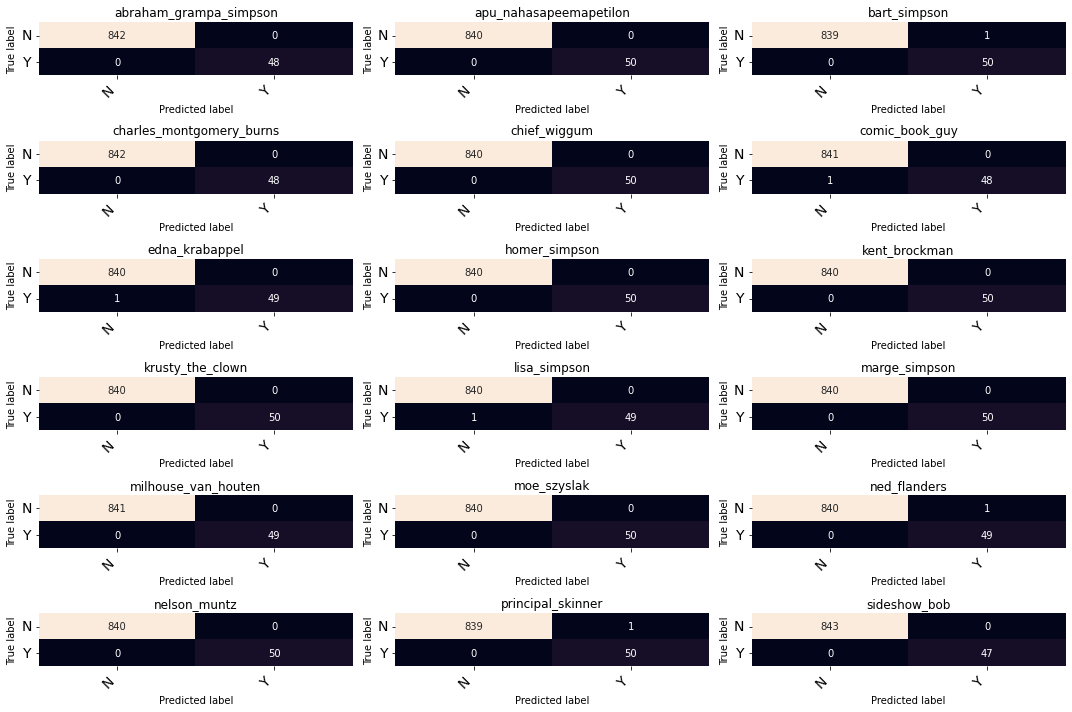

Reporte por cada clase del modelo 4
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        48
           1       0.98      1.00      0.99        50
           2       0.75      0.80      0.78        50
           3       0.83      0.92      0.87        48
           4       0.96      0.92      0.94        50
           5       1.00      0.80      0.89        49
           6       0.94      0.90      0.92        50
           7       0.85      0.90      0.87        50
           8       0.98      0.96      0.97        50
           9       0.94      1.00      0.97        50
          10       0.91      0.62      0.74        50
          11       0.94      0.96      0.95        50
          12       0.96      0.98      0.97        49
          13       0.86      1.00      0.93        50
          14       0.91      1.00      0.95        49
          15       0.96      0.90      0.93        50
          16       0.88      1.00      0.93  

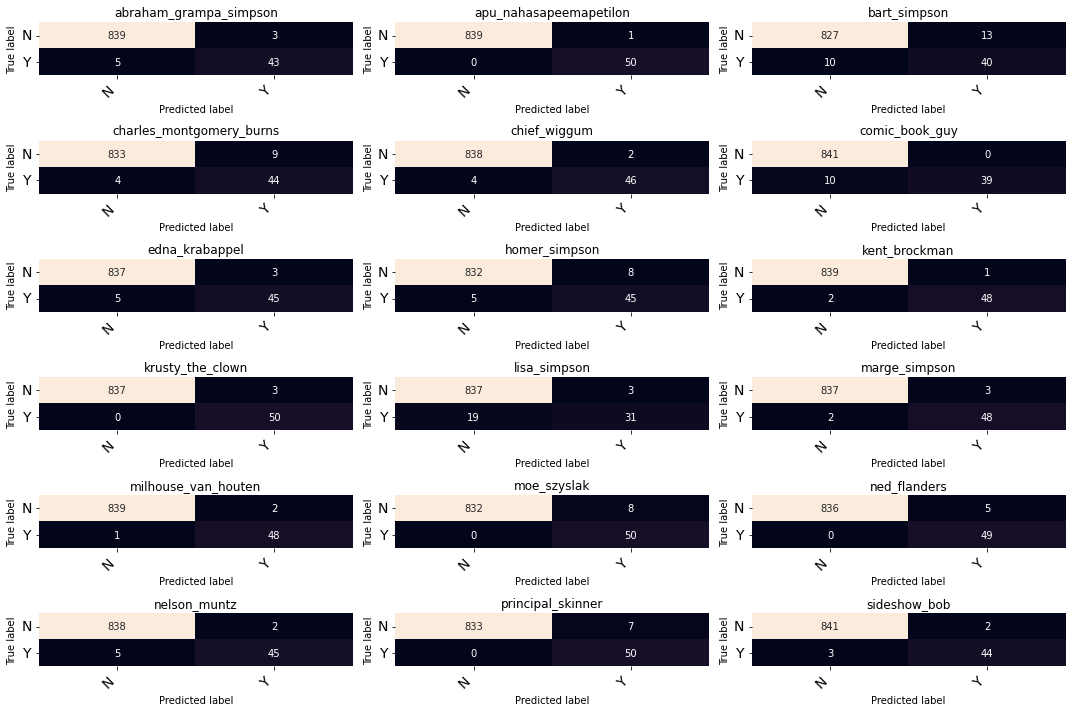

Reporte por cada clase del modelo 5
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        48
           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        50
           3       0.98      1.00      0.99        48
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        49
           6       1.00      0.98      0.99        50
           7       1.00      0.98      0.99        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50
          10       0.98      1.00      0.99        50
          11       1.00      1.00      1.00        50
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        50
          14       1.00      0.98      0.99        49
          15       1.00      1.00      1.00        50
          16       1.00      1.00      1.00  

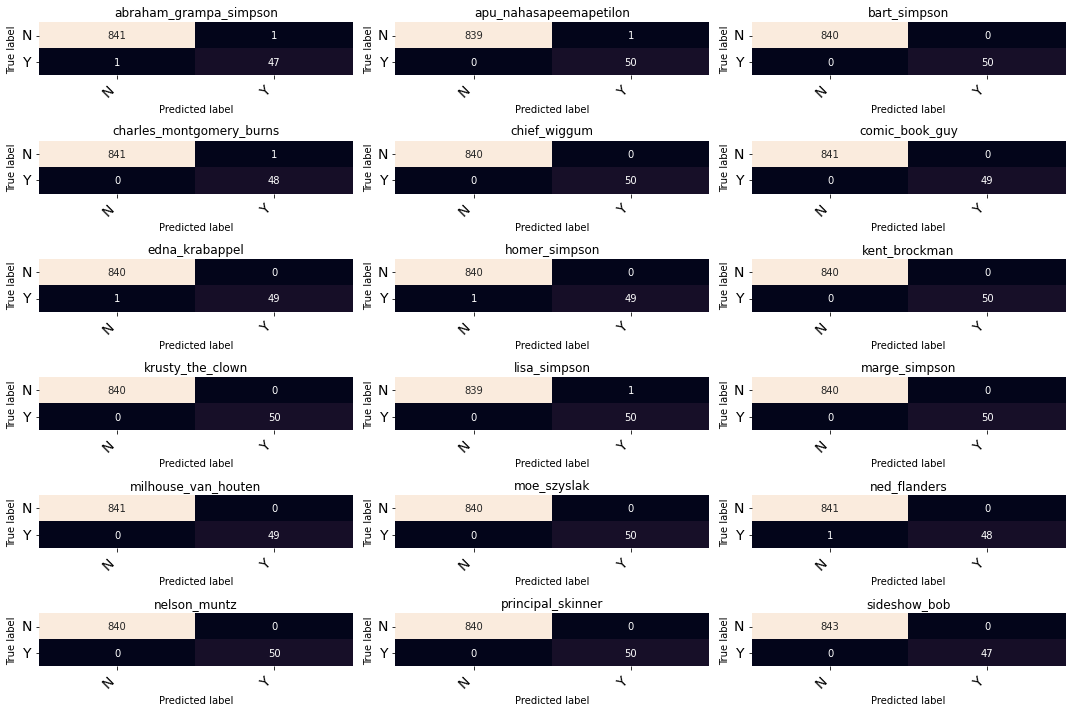

Reporte por cada clase del modelo 6
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        48
           1       0.98      1.00      0.99        50
           2       0.94      1.00      0.97        50
           3       0.96      1.00      0.98        48
           4       1.00      0.98      0.99        50
           5       0.98      1.00      0.99        49
           6       1.00      0.96      0.98        50
           7       0.94      0.96      0.95        50
           8       1.00      0.98      0.99        50
           9       1.00      1.00      1.00        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       1.00      1.00      1.00        49
          13       0.94      1.00      0.97        50
          14       0.98      1.00      0.99        49
          15       1.00      0.98      0.99        50
          16       0.98      1.00      0.99  

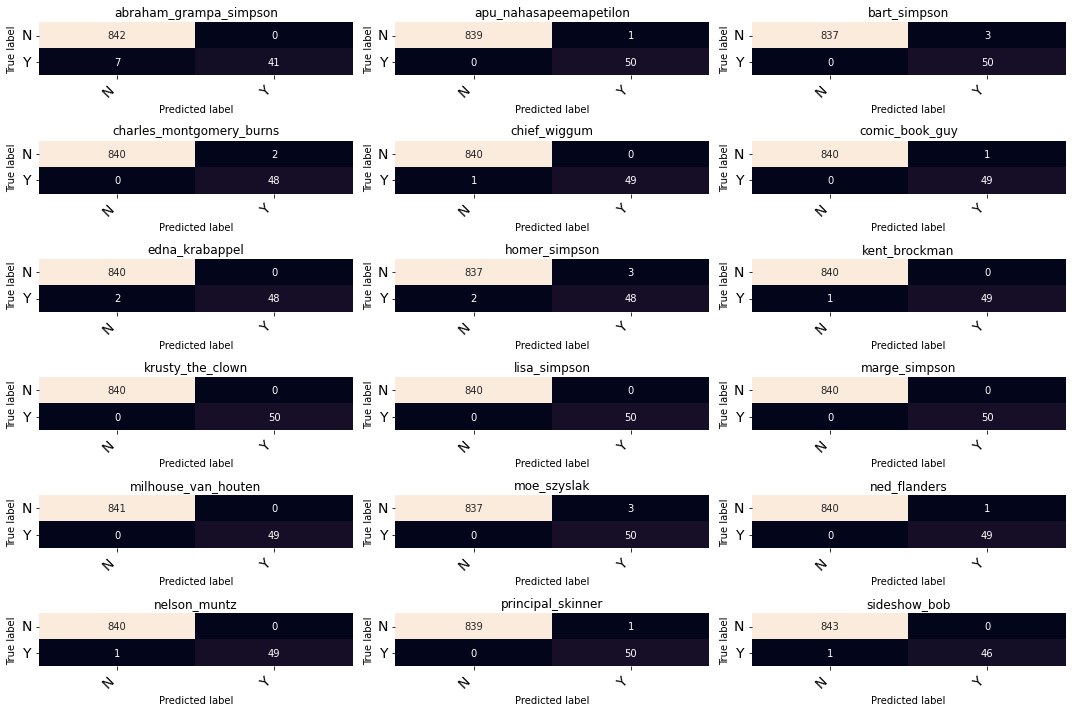

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

for key, model in enumerate(models):
  classifications = model.predict(X_t) 
  classifications  = classifications.argmax(axis=1) 
  print("Reporte por cada clase del modelo " + str(key + 1))
  print(classification_report(y_t, classifications))
  
  cm = multilabel_confusion_matrix(y_t, classifications)
  fig, ax = plt.subplots(6, 3, figsize=(15, 10))  
  for axes, cfs_matrix, label in zip(ax.flatten(), cm, list(MAP_CHARACTERS.values())):
      print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
  fig.tight_layout()
  plt.show()

#Conclusiones:



*   El comportamiento de las CNN depende directamente de la modificacion previa de los datos, lo que se puede entender como un preprocesamiento o procesamiento de la informacion que hacen que para la ejecucion de sentencias de la CNN se presenten resultados variantes, ademas del ajuste de variables a categorical junto a la correcta incicializacion de parametros, que dependen directamente del problema a solucionar, para este caso personajes de la serie los Simpson.

*  El ajustar parametros, conjunto de operaciones por sentencia o por capa, ademas el modificar o agregar estructras basadas en funciones sobre los resultados es de gran utilidad para el objetivo de una buena precision en la inferencia, puesto que en la creacion de modelos y comparacion de resultados, se pueden ajustar los parametros que garanticen una mejora gradual en los resultados. 

Sobre los resultados obtenidos podemos indicar lo siguiente:

*  Se configuraron 6 escenarios de reds CNN con variados parametros de neuronas y caracteristicas de las capas, todas estas manteniendo una estructura básica de CNN. 

*  Todos los modelos generados cumplieron el objetivo de cumplir con una precision superior al 85%, lo que nos indica que, en lo general, las CNN son muy buenas en su tarea de clasificar. Mas aun, no fue dificil, con pocas sintonias, el conseguir los mínimos requeridos.  

*  De los resultados obtenidos, aun cuando se sobrepasaron los valores de precision del 95%, algunos modelos se mostraron mas efectivos en su labor de clasificacion. En particular, el modelo 3 presento valores de loss: loss: 0.0152 - accuracy: 0.9966

* Las validaciones usando matriz de confusion para los 6 modelos tambien presentaron muy buenos resultados. En lo general los modelos fueron muy buenos para detectar los Verdaderos positivos y tambien para la deteccion de los falsos negativos. 

* Cabe hacer notar que estos buenos resultados se consiguieron usando solo 15 epochs, un modelo de muchas imagenes y de una amplia cantidad de clases puede requerir de muchas mas epocas para su afinamiento, lo que vuelve a hablar de la calidad de las CNN para las labores de clasificacion

*  Este modelo es complejo ya que cuenta con variadas capas incluyendo mezclas de capas de convolucion con maxpooling y dropout.


* Se diseño y configuro una prueba incorporando Data Augmentation usando la clase ImageDataGenerator de Keras. En general los resultados obtenidos no sobrepasaron el porcentaje de 85% de precision solicitada, por lo que no se incorporaron los resultados y codigos en la experiencia. Solo se quiere acotar que en principio, para esta aplicación, en donde se cuenta con un numero importante de muestras, el aumentar el tamaño del dataset traves de la tecnica de data augmentation no represento una verdadera mejora, mas aun, los modelos utilizados, en su mayoria se comportaron muy erraáticos y con baja tada de precision. Solo en un caso se presentaron datos aceptables y fue cuando el modelo de red convolucional incorporaba entre capas algunas rutinas de batch normalization.      




